In [ ]:
! pip install emoji
! pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.1 MB/s eta 0:00:00


Total Media Messages: 0
Total Emojis: 16
Total Links: 15
('👍', 60)
('👌', 9)
('👍🏻', 7)
('😄', 2)
('🤝🏻', 2)
('😅', 2)
('🙈', 2)
('🙌', 2)
('\U0001fae1', 1)
('😕', 1)
('🤝', 1)
('🥳', 1)
('😍', 1)
('❤️', 1)
('🧐', 1)
('\U0001fae3', 1)
There are 149680 words in all the messages.


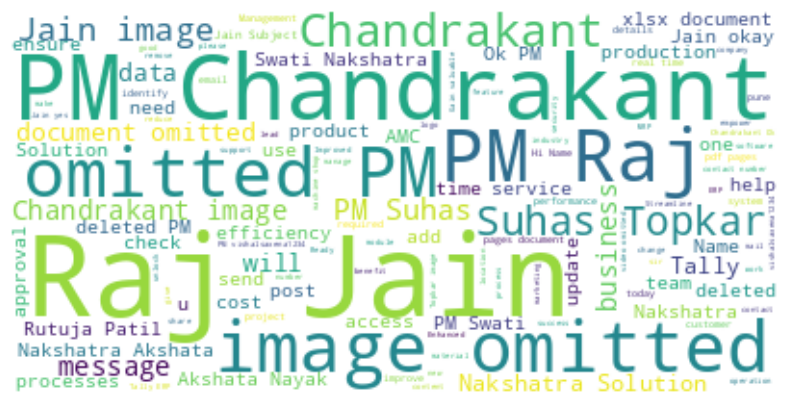

In [ ]:
import regex as re
import pandas as pd
import numpy as np
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

def startsWithDateAndTime(s):
    pattern = r'^\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2} [AP]M -'
    result = re.match(pattern, s)
    return bool(result)

def getDataPoint(line):
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(', ')
    message = ' '.join(splitLine[1:])
    if ':' in message:
        splitMessage = message.split(': ')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

# File path for the uploaded WhatsApp text file
conversation = '/content/_chat.txt'

parsedData = []

with open(conversation, encoding="utf-8") as fp:
    fp.readline()  # Skipping the first line
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
                messageBuffer.clear()
            date, time, author, message = getDataPoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
    if len(messageBuffer) > 0:
        parsedData.append([date, time, author, ' '.join(messageBuffer)])

df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])

# Counting media messages
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]

def split_count(text):
    emoji_list = [emoji.demojize(e) for e in emoji.distinct_emoji_list(text)]
    return emoji_list

df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())

URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

# Filter out media messages for further analysis
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

# Adding columns for letter count, word count, and initializing message count
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s: len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s: len(s.split(' ')))
messages_df["MessageCount"] = 1

# List of authors in the group
authors = messages_df['Author'].unique()

# Iterating through each author and calculating statistics
for author in authors:
    if author is None:
        continue
    req_df = messages_df[messages_df["Author"] == author]
    print(f'\nStats of {author} -')
    print('Messages Sent:', req_df.shape[0])
    words_per_message = (np.sum(req_df['Word_Count'])) / req_df.shape[0]
    print('Words per message:', words_per_message)
    media = media_messages_df[media_messages_df['Author'] == author].shape[0]
    print('Media Messages Sent:', media)
    emojis = sum(req_df['Message'].apply(lambda s: emoji.emoji_count(s)))
    print('Emojis Sent:', emojis)
    links = sum(req_df['Message'].apply(lambda s: len(re.findall(r'(https?://\S+)', s))))
    print('Links Sent:', links)

print("Total Media Messages:", media_messages)
print("Total Emojis:", emojis)
print("Total Links:", links)

# Extract emojis from messages
messages_df['Emojis'] = messages_df['Message'].apply(lambda s: [e['emoji'] for e in emoji.emoji_list(s)])
total_emojis_list = list([a for b in messages_df['Emojis'] for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

for i in emoji_dict:
    print(i)

text = " ".join(review for review in messages_df.Message)
print("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()